<a href="https://colab.research.google.com/github/tamimisalah/Car-Insurance-Claim-Prediction/blob/main/Car_Insurance_Colab_Ready.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚗 Car Insurance Claim Prediction
This notebook walks through data cleaning, modeling, and interpretation using a car insurance dataset.

In [4]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
df = pd.read_csv('/content/drive/MyDrive/Car_Insurance_Claim.csv')
df.head()

,ID,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
0,569520,65+,female,majority,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,750365,16-25,male,majority,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,199901,16-25,female,majority,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,478866,16-25,male,majority,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,731664,26-39,male,majority,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


## 🧹 Data Cleaning

In [7]:
# Drop uninformative columns
df = df.drop(columns=['ID', 'POSTAL_CODE'])

# Fill missing values
df['CREDIT_SCORE'] = df['CREDIT_SCORE'].fillna(df['CREDIT_SCORE'].median())
df['ANNUAL_MILEAGE'] = df['ANNUAL_MILEAGE'].fillna(df['ANNUAL_MILEAGE'].median())
df['OUTCOME'] = df['OUTCOME'].astype(int)
df.isnull().sum()

,0
AGE,0
GENDER,0
RACE,0
DRIVING_EXPERIENCE,0
EDUCATION,0
INCOME,0
CREDIT_SCORE,0
VEHICLE_OWNERSHIP,0
VEHICLE_YEAR,0
MARRIED,0


## 📊 Exploratory Visualizations

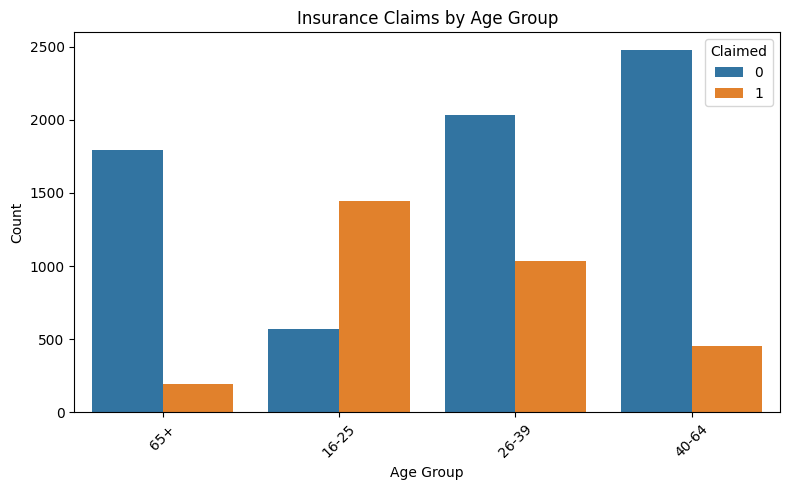

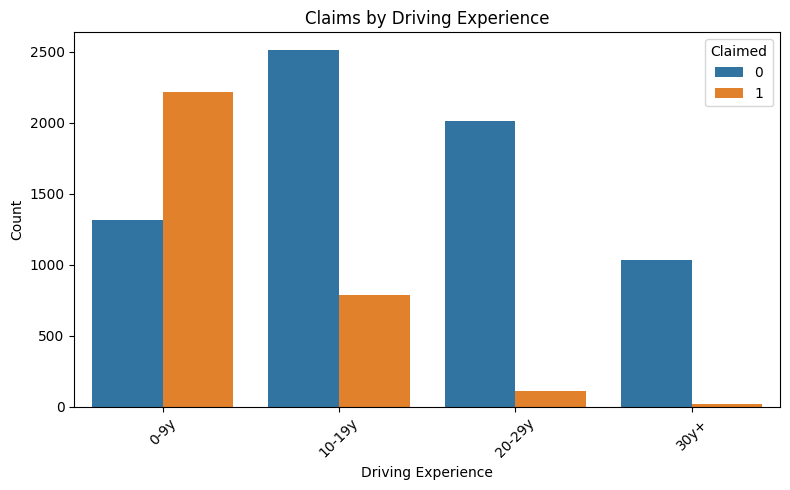

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Age
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='AGE', hue='OUTCOME')
plt.title('Insurance Claims by Age Group')
plt.xlabel('Age Group'); plt.ylabel('Count'); plt.xticks(rotation=45)
plt.legend(title='Claimed'); plt.tight_layout()
plt.show()

# Driving Experience
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='DRIVING_EXPERIENCE', hue='OUTCOME')
plt.title('Claims by Driving Experience')
plt.xlabel('Driving Experience'); plt.ylabel('Count'); plt.xticks(rotation=45)
plt.legend(title='Claimed'); plt.tight_layout()
plt.show()

## 🤖 Model Training & Feature Importance

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance

X = df.drop(columns='OUTCOME')
y = df['OUTCOME']

cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(exclude='object').columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('cat', cat_pipe, cat_cols)
], remainder='passthrough')

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=42))
])

pipe.fit(X_train, y_train)

# Permutation importance
perm = permutation_importance(pipe, X_test, y_test, n_repeats=10, random_state=42)

# Match names
feature_names = pipe.named_steps['preprocessor'].get_feature_names_out()
perm_df = pd.DataFrame({
    'Feature': feature_names[:len(perm.importances_mean)],
    'Importance': perm.importances_mean
}).sort_values(by='Importance', ascending=False)

perm_df.head(10)

,Feature,Importance
3,cat__AGE_65+,0.04916
7,cat__RACE_minority,0.03452
8,cat__DRIVING_EXPERIENCE_0-9y,0.03380
1,cat__AGE_26-39,0.01340
15,cat__INCOME_middle class,0.00872
13,cat__EDUCATION_none,0.00292
11,cat__DRIVING_EXPERIENCE_30y+,0.00208
5,cat__GENDER_male,0.00148
12,cat__EDUCATION_high school,0.00144
9,cat__DRIVING_EXPERIENCE_10-19y,0.00004


## 📈 Explanatory Visualizations for Stakeholders

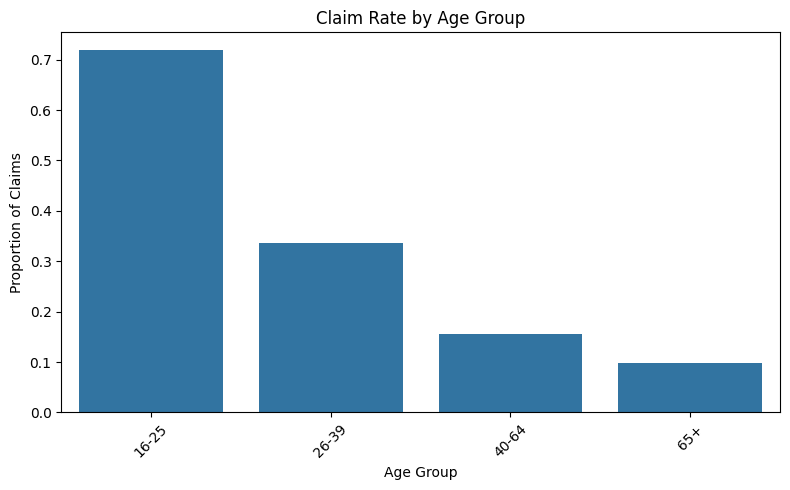

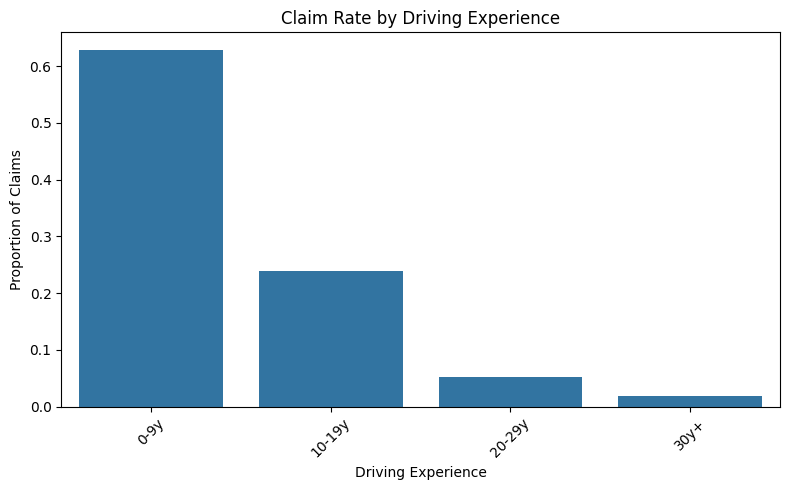

In [10]:
# AGE vs OUTCOME
age_claims = df.groupby('AGE')['OUTCOME'].mean().reset_index()
plt.figure(figsize=(8,5))
sns.barplot(data=age_claims, x='AGE', y='OUTCOME')
plt.title('Claim Rate by Age Group')
plt.xlabel('Age Group'); plt.ylabel('Proportion of Claims'); plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# DRIVING_EXPERIENCE vs OUTCOME
exp_claims = df.groupby('DRIVING_EXPERIENCE')['OUTCOME'].mean().reset_index()
plt.figure(figsize=(8,5))
sns.barplot(data=exp_claims, x='DRIVING_EXPERIENCE', y='OUTCOME')
plt.title('Claim Rate by Driving Experience')
plt.xlabel('Driving Experience'); plt.ylabel('Proportion of Claims'); plt.xticks(rotation=45)
plt.tight_layout()
plt.show()